In [63]:
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
from datetime import date
import numpy as np
from sklearn.cluster import KMeans
from skimage.morphology import skeletonize
import cv2
from shapely.geometry import LineString , MultiPoint, box
from itertools import combinations
import pandas as pd

In [3]:

# Load the binary GeoTIFF image
with rasterio.open('overlap_zeors.tif') as src:
    track_image = src.read(1)  # Assuming the track is in the first band
    transform = src.transform   # Affine transformation for converting pixel to geo-coordinates

track_image = ((track_image - track_image.min()) / (track_image.max() - track_image.min())) * 255
track_image = track_image.astype(np.uint8)


contours, hierarchy = cv2.findContours(track_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contours = sorted(contours, key=cv2.contourArea, reverse=True)

track_image_color = cv2.cvtColor(track_image, cv2.COLOR_GRAY2BGR)

cv2.drawContours(track_image_color,contours[2], -1, (255, 0, 0), 7) 
smaller_image = cv2.resize(track_image_color, (0, 0), fx=0.25, fy=0.25)

# Display the resized image
# cv2.imshow('Contours', smaller_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [4]:
mask = np.zeros_like(track_image, dtype=np.uint8)
cv2.drawContours(mask, contours[:4], -1, 255, thickness=cv2.FILLED)
extracted_pixels = np.where(mask == 255, 255, 0).astype(np.uint8)
extracted_pixels = cv2.blur(extracted_pixels,(5,5),0)

In [5]:
_,extracted_pixels = cv2.threshold(extracted_pixels,127,255,type=cv2.THRESH_BINARY)

In [6]:
def overlap_binary(geotiff, padded_image):
    query_img = geotiff  
    train_img = padded_image 


    plt.figure(figsize=(10, 10))

    plt.imshow(train_img, cmap='Blues', alpha=1)
    plt.imshow(query_img, cmap='Reds', alpha=0.1)

    

    plt.title('Overlapping Binary Images')
    plt.show()

In [7]:
padded_img = cv2.imread('padded_image_blur.tif')
padded_img = cv2.cvtColor(padded_img,cv2.COLOR_BGR2GRAY)
kernel = np.ones((3, 3), np.uint8) 

# dilate the image 
padded_img = cv2.erode(padded_img, kernel, iterations=8) 
skeleton = skeletonize(extracted_pixels)
skeleton =(skeleton*255).astype(np.uint8)


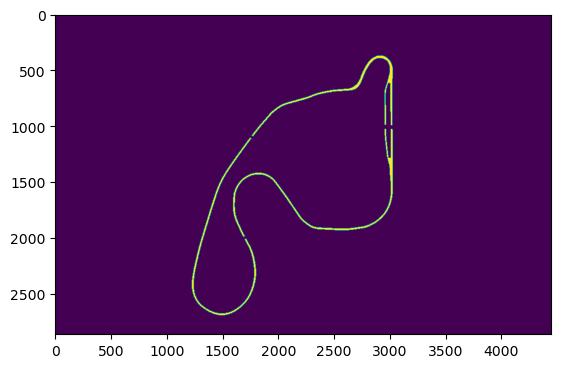

In [8]:
plt.imshow(padded_img)

In [9]:
# Save the binary image as a new GeoTIFF file
with rasterio.open(
    'skeleton2.tif',
    'w',
    driver='GTiff',
    height=skeleton.shape[0],
    width=skeleton.shape[1],
    count=1,  # Single band for the binary image
    dtype=skeleton.dtype,
    crs=src.crs,
    transform=src.transform
) as dst:
    dst.write(skeleton, 1)

print("Binary image saved as 'padded_img.tif'")


Binary image saved as 'padded_img.tif'


In [10]:
from rasterio.transform import rowcol
import geopandas as gpd
from shapely.geometry import Point, LineString, LinearRing, Polygon, MultiLineString , GeometryCollection,MultiPoint
from shapely.ops import split
from shapely.geometry.polygon import orient

def pixel_to_geo(transform, x, y):
    lon, lat = rasterio.transform.xy(transform, y, x)
    return lon, lat

In [11]:
first = contours[:4]

geometries = []


for contour in first:
    contour = contour.reshape(contour.shape[0],-1)
    all_points = [pixel_to_geo(transform, point[0], point[1]) for point in contour]
    geometries.append(all_points)


line = GeometryCollection([LineString(cont) for cont in geometries])
boundary_geom = gpd.GeoDataFrame(
    {'geometry': [line]},
    crs="EPSG:3857"  # Assuming WGS84 coordinate system
)

In [12]:
import whitebox
from shapely.wkt import loads

In [13]:
wbt = whitebox.WhiteboxTools()

In [14]:
wbt.raster_to_vector_lines('skeleton2.tif','some.shp')

.\whitebox_tools.exe --run="RasterToVectorLines" --input='skeleton2.tif' --output='some.shp' -v --compress_rasters=False

**********************************
* Welcome to RasterToVectorLines *
* Powered by WhiteboxTools       *
* www.whiteboxgeo.com            *
**********************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 4

0

In [15]:
line = gpd.read_file('some.shp')
line = line[line.length>10]
line = line['geometry']

In [16]:
from shapely.geometry import LineString, Point
import math

# Function to extend a line string by a given distance on both sides
def extend_line_by_distance_both_sides(line: LineString, distance: float) -> LineString:
    # Get the first two points of the line string (for extending the start)
    p1_start = Point(line.coords[0])
    p2_start = Point(line.coords[1])

    # Get the last two points of the line string (for extending the end)
    p1_end = Point(line.coords[-2])
    p2_end = Point(line.coords[-1])

    # Calculate the direction vectors for the first and last segments
    direction_vector_start = (p1_start.x - p2_start.x, p1_start.y - p2_start.y)
    direction_vector_end = (p2_end.x - p1_end.x, p2_end.y - p1_end.y)

    # Calculate the lengths of the first and last segments
    length_start = math.sqrt(direction_vector_start[0]**2 + direction_vector_start[1]**2)
    length_end = math.sqrt(direction_vector_end[0]**2 + direction_vector_end[1]**2)

    # Normalize the direction vectors
    normalized_vector_start = (direction_vector_start[0] / length_start, direction_vector_start[1] / length_start)
    normalized_vector_end = (direction_vector_end[0] / length_end, direction_vector_end[1] / length_end)

    # Extend both the start and end by the desired distance
    extended_start_x = p1_start.x + normalized_vector_start[0] * distance
    extended_start_y = p1_start.y + normalized_vector_start[1] * distance
    extended_end_x = p2_end.x + normalized_vector_end[0] * distance
    extended_end_y = p2_end.y + normalized_vector_end[1] * distance

    # Create new points for the extended start and end
    new_start_point = Point(extended_start_x, extended_start_y)
    new_end_point = Point(extended_end_x, extended_end_y)

    # Create a new LineString with the extended points
    extended_line = LineString([new_start_point] + list(line.coords) + [new_end_point])

    return extended_line




In [17]:
new_line = []
for i in line:
    extended_line = extend_line_by_distance_both_sides(i, 2)
    new_line.append(extended_line)

new_gdf = gpd.GeoSeries(new_line,crs='3857')

In [18]:
colln = []
for a, i in zip(line.keys(),new_gdf):

    points= []
    for j in new_gdf:
        if i!=j :

            if i.intersects(j):

                intersect = i.intersection(j)
                
                
                if isinstance(intersect,MultiLineString):
                    points.extend([Point(intersect.geoms[0].coords[0])])


                elif isinstance(intersect,LineString):
                    points.extend([Point(intersect.coords[0])])

    

    colln.extend([i for i in split(line[a],MultiPoint(points)).geoms])

    
    # break

In [19]:
colln = gpd.GeoSeries(colln,crs='3857')
colln_gdf = gpd.GeoDataFrame(geometry=colln, crs='3857')
colln_gdf = colln_gdf[colln_gdf.length>10]

In [20]:
colln_gdf.reset_index(drop=True,inplace=True)

In [21]:
def calculate_midpoint(line):
    if isinstance(line, LineString):  # Ensure the geometry is a LineString
        total_length = line.length  # Get the total length of the LineString
        return line.interpolate(total_length / 2)  # Get the midpoint
    return None

In [22]:
colln_gdf['midpoint'] = colln_gdf.geometry.apply(calculate_midpoint)

<Axes: >

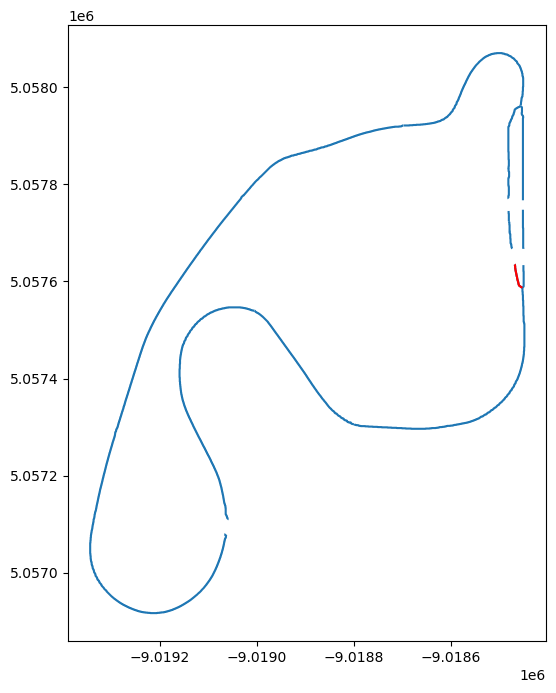

In [23]:
i=6
fig, ax = plt.subplots(figsize=(10, 8))
colln_gdf.plot(ax = ax)
colln_gdf.iloc[i:i+1].plot(ax=ax,color='red')

In [24]:
minx, miny, maxx, maxy = colln_gdf.unary_union.bounds

In [25]:
def get_indexes(gdf):

    if len(gdf.index) == 1:
        return int(gdf.index[0])
    
    elif len(gdf.index)>1:
        max_distance = 0
        max_pair = (None, None)

        # Use combinations to generate all possible pairs of midpoints
        for (idx1, row1), (idx2, row2) in combinations(gdf.iterrows(), 2):
            midpoint1 = row1['midpoint']
            midpoint2 = row2['midpoint']
            
            # Calculate the distance between the two midpoints
            distance = midpoint1.distance(midpoint2)
            
            # Check if this distance is the largest so far
            if distance > max_distance:
                max_distance = distance
                max_pair = (idx1, idx2)
        return max_pair
    else:
        return None

In [26]:
div = 100
x_extend = maxx-minx
y_extend = maxy - miny

indexes = {}
x_list = [minx]
y_list = [miny]
for i in range(div):
    x_list.append(x_list[-1]+x_extend/div)
    y_list.append(y_list[-1]+y_extend/div)

for i in x_list:
    
   sel = colln_gdf[colln_gdf['geometry'].apply(lambda x: x.intersects(LineString([[i,maxy],[i,miny]])))]
   index = get_indexes(sel)


   if isinstance(index,int):
      if index not in indexes.keys():
         indexes[index]=1
      else:
         indexes[index]+=1

   elif isinstance(index,tuple):
      if index[0] not in indexes.keys():
         indexes[index[0]]=1
      else:
         indexes[index[0]]+=1

      if index[1] not in indexes.keys():
             indexes[index[1]]=1
      else:
         indexes[index[1]]+=1                   


for i in y_list:

   sel = colln_gdf[colln_gdf['geometry'].apply(lambda x: x.intersects(LineString([[minx,i],[maxx,i]])))]
   index = get_indexes(sel)


   if isinstance(index,int):
      if index not in indexes.keys():
         indexes[index]=1
      else:
         indexes[index]+=1

   elif isinstance(index,tuple):
      if index[0] not in indexes.keys():
         indexes[index[0]]=1
      else:
         indexes[index[0]]+=1

      if index[1] not in indexes.keys():
             indexes[index[1]]=1
      else:
         indexes[index[1]]+=1                   



In [27]:
indexes

{0: 161, 10: 33, 9: 23, 7: 66, 11: 39, 8: 4, 3: 7, 2: 17}

In [28]:
colln_gdf['count'] = colln_gdf.index.map(indexes)
colln_gdf['count'] = colln_gdf['count'].fillna(0)
colln_gdf['ratio'] = colln_gdf['count']/colln_gdf.length

In [29]:
colln_gdf = colln_gdf[colln_gdf['ratio']>0.02]

In [30]:
line = colln_gdf['geometry']

In [31]:
terminal_line = {}
for i,l in enumerate(line):
    terminal_line[i] = (l.coords[0],l.coords[-1])
    
segments = [i for i in line]
ordered_segments = []
ordered_segments.append(segments[0])

for i in range(len(segments)-1):

    ref = ordered_segments[-1].coords[-1]

    diff = []
    for j in range(len(segments)):
        f, l = terminal_line[j]  # Get start (f) and end (l) points of the j-th line
        dist_start = Point(ref).distance(Point(f))  # Distance from ref to start
        dist_end = Point(ref).distance(Point(l))    # Distance from ref to end
        diff.append((dist_start, dist_end, j))

    sorted_distance = sorted(diff, key=lambda x: min(x[0], x[1]))
    min_distance = (sorted_distance[1])

    if min_distance[0]>min_distance[1]:
        ordered_segments.append(segments[min_distance[2]].reverse())
    else:
        ordered_segments.append(segments[min_distance[2]])

In [32]:
line = gpd.GeoSeries(ordered_segments)

In [33]:
def get_right_point(boundary):
    point_list = [point for point in boundary.geoms]
    for i in range(1,len(point_list)):
        l = point_list[0].distance(point_list[i])

        if l>6:
            return point_list[0], point_list[i]

In [38]:
import numpy as np


boundaries = []
for f in line.keys():
    # Number of meters to interpolate
    distance_per_point = 6  # meters

    # Calculate the total length of the specified line
    total_length = line[f].length

    # Calculate the number of points based on the desired distance
    num_points = int(total_length // distance_per_point)

    # Generate interpolated points at 2-meter intervals
    interpolated_points = [line[f].interpolate(i * distance_per_point).xy for i in range(num_points + 1)]

    
    points = []
    line_length = 10  # Length of the perpendicular line

    for i in range(len(interpolated_points) - 1):
        x1, y1 = interpolated_points[i]  # First point
        x2, y2 = interpolated_points[i + 1]  # Second point

        x1, y1 = x1[0], y1[0]
        x2, y2 = x2[0], y2[0]

        # Calculate the direction vector
        direction_vector = np.array([x2 - x1, y2 - y1])
        
        # Normalize the direction vector
        norm = np.linalg.norm(direction_vector)
        if norm != 0:
            direction_vector /= norm

        # Rotate the vector 90 degrees clockwise
        # [cos(theta), -sin(theta)]
        # [sin(theta), cos(theta)]
        # For 90 degrees clockwise, we swap and negate the x component
        perpendicular_vector = np.array([direction_vector[1], -direction_vector[0]]) * line_length

        # Calculate the endpoints of the perpendicular line
        x_start, y_start = x1 - perpendicular_vector[0], y1 - perpendicular_vector[1]  # One end of the perpendicular line
        x_end, y_end = x1 + perpendicular_vector[0], y1 + perpendicular_vector[1]      # The other end of the perpendicular line
        

        all_points = boundary_geom.geometry[0].intersection(LineString([[x_start, y_start], [x_end, y_end]]))


        if isinstance(all_points,MultiPoint):
            selected = get_right_point(all_points)
            if selected is not None:
                dist = [p.distance(Point(x_start,y_start)) for p in selected]
                if dist[0]>dist[1]:
                    selected = (selected[1], selected[0])
                boundaries.append(selected)
        
        # break


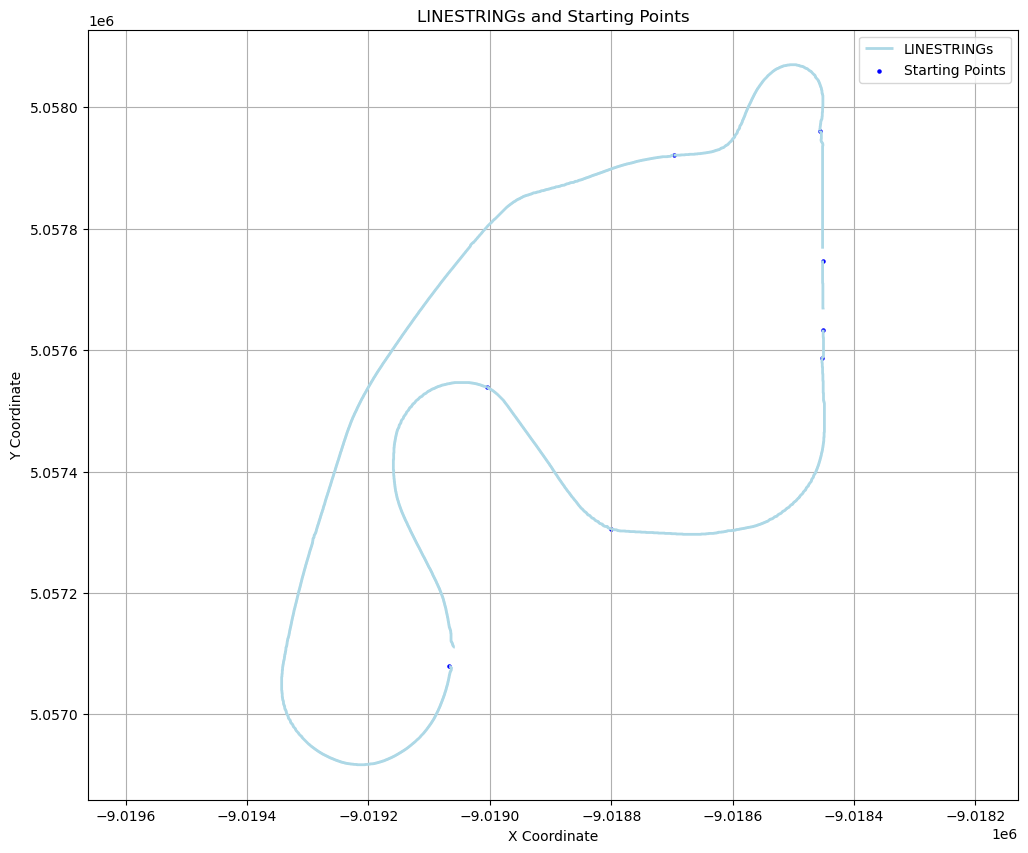

In [39]:

# Extract starting points
start_points = [(line.coords[0]) for line in line]
end_points = [(line.coords[-1]) for line in line]

# Create a DataFrame for the starting points
start_points_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy([pt[0] for pt in start_points], [pt[1] for pt in start_points]))
end_points_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy([pt[0] for pt in end_points], [pt[1] for pt in end_points]))

# Plotting
plt.figure(figsize=(12, 10))

# Plot the lines
line.plot(ax=plt.gca(), color='lightblue', linewidth=2, label='LINESTRINGs')

# Plot the starting points
# start_points_gdf.plot(ax=plt.gca(), color='red', marker='o', markersize=30, label='Starting Points')
end_points_gdf.plot(ax=plt.gca(), color='blue', marker='o', markersize=5, label='Starting Points')

# Customizing the plot
plt.title('LINESTRINGs and Starting Points')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid()
plt.legend()
plt.axis('equal')  # To maintain the aspect ratio
plt.show()

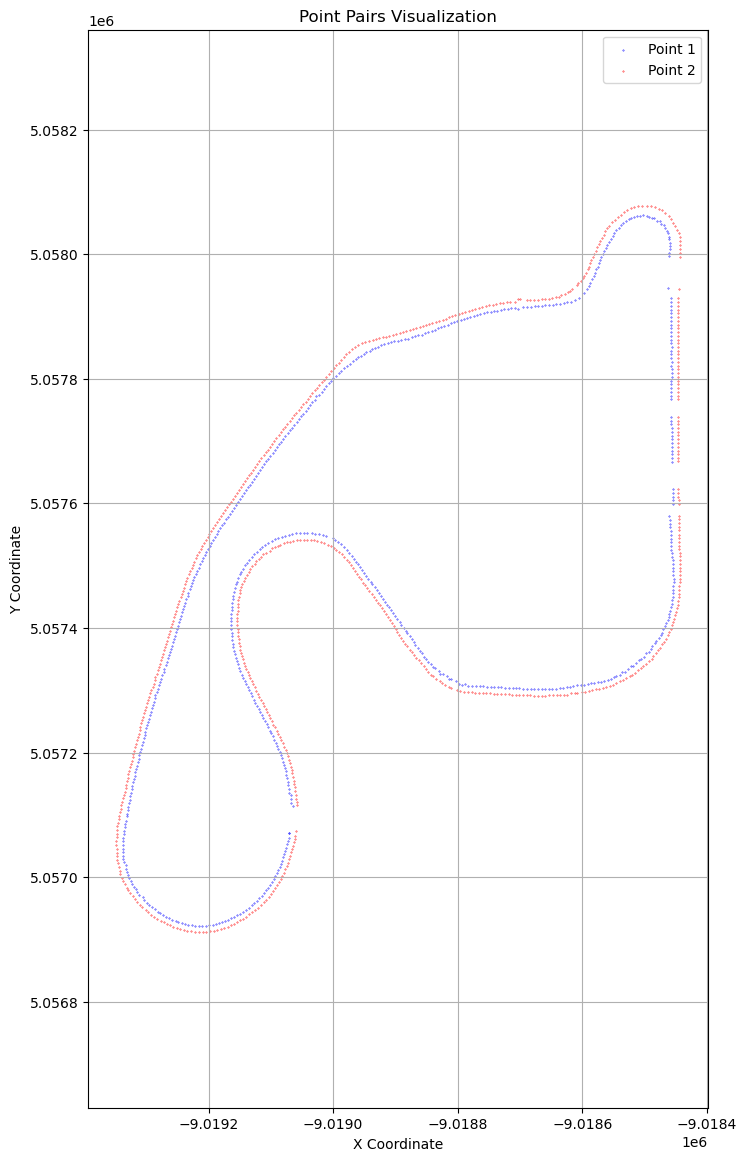

In [40]:
x_coords1 = []
y_coords1 = []
x_coords2 = []
y_coords2 = []

for pair in boundaries:
    point1 = pair[0]  # Load first point
    point2 = pair[1]  # Load second point
    x_coords1.extend([point1.x])
    y_coords1.extend([point1.y])
    x_coords2.extend([point2.x])  # Corrected to use point2
    y_coords2.extend([point2.y])  # Corrected to use point2

# Create a scatter plot
x=800
plt.figure(figsize=(8, 14))
plt.scatter(x_coords1[:x], y_coords1[:x], color='blue', label='Point 1',s=0.1)
plt.scatter(x_coords2[:x], y_coords2[:x], color='red', label='Point 2',s=0.1)

# Adding titles and labels
plt.title("Point Pairs Visualization")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")

# Set equal scaling
plt.axis('equal')

# Show the grid
plt.grid(True)

# Add a legend to distinguish points
plt.legend()

# Show the plot
plt.show()

In [41]:
points = [point for pair in boundaries for point in pair]
final_points = gpd.GeoDataFrame(geometry=points)
final_points.to_file('final_points.shp')

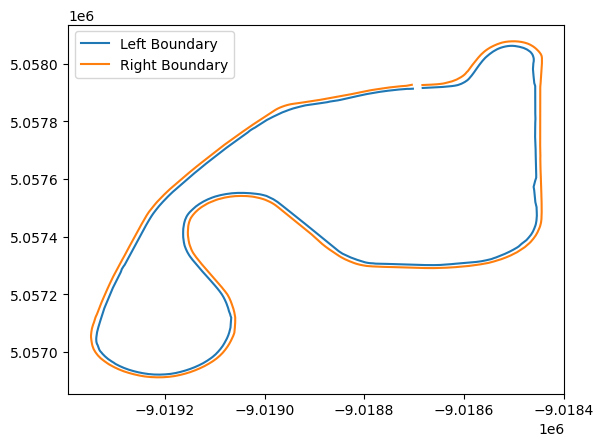

In [262]:
import numpy as np
import matplotlib.pyplot as plt

left_boundary = np.array([i[0].coords[0] for i in boundaries])
right_boundary = np.array([i[1].coords[0] for i in boundaries])

# Moving average function
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply moving average to both x and y coordinates of the boundaries
left_boundary_x = left_boundary[:,0] # Add all left x coordinates here
left_boundary_y = left_boundary[:,1]  # Add all left y coordinates here

right_boundary_x = right_boundary[:,0]# Add all right x coordinates here
right_boundary_y = right_boundary[:,1]   # Add all right y coordinates here

# Apply moving average to smooth the data
smoothed_left_x = moving_average(left_boundary_x)
smoothed_left_y = moving_average(left_boundary_y)

smoothed_right_x = moving_average(right_boundary_x)
smoothed_right_y = moving_average(right_boundary_y)

# Plot the smoothed boundaries for visualization
plt.plot(smoothed_left_x, smoothed_left_y, label='Left Boundary')
plt.plot(smoothed_right_x, smoothed_right_y, label='Right Boundary')
plt.legend()
plt.show()


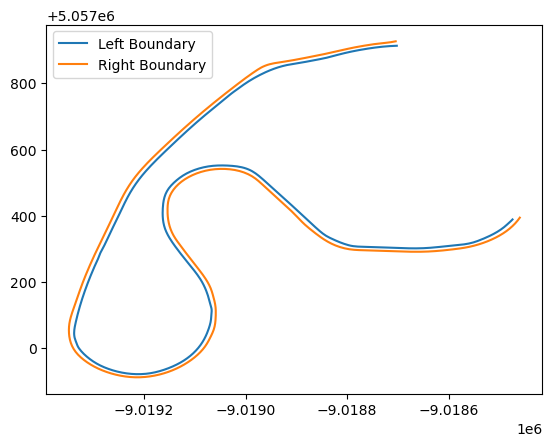

In [285]:
import numpy as np
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt

# Input points (convert the coordinates into numpy arrays for left and right boundaries)
left_boundary = np.array([(x,y) for x,y in zip(smoothed_left_x,smoothed_left_y)])  # Add all your points here
right_boundary = np.array([(x,y) for x,y in zip(smoothed_right_x,smoothed_right_y)])



# Apply spline interpolation to smooth the boundaries
def smooth_boundary(boundary):
    x, y = boundary[:,0], boundary[:,1]
    tck, u = splprep([x, y], s=10)  # s is the smoothing factor, adjust it as needed
    x_smooth, y_smooth = splev(np.linspace(0, 1, 800), tck)
    return x_smooth, y_smooth

left_x_smooth, left_y_smooth = smooth_boundary(left_boundary)
right_x_smooth, right_y_smooth = smooth_boundary(right_boundary)

# Plot the smoothed boundaries for visualization
plt.plot(left_x_smooth[:600], left_y_smooth[:600], label='Left Boundary')
plt.plot(right_x_smooth[:600], right_y_smooth[:600], label='Right Boundary')
plt.legend()
plt.show()


In [268]:
# smoothed_left_boundary = gpd.GeoDataFrame(geometry= [Point(x,y) for x,y in zip(smoothed_left_x,smoothed_left_y)],crs='EPSG:3857').to_crs(epsg=4326)
# smoothed_right_boundary = gpd.GeoDataFrame(geometry= [Point(x,y) for x,y in zip(smoothed_right_x,smoothed_right_y)],crs='EPSG:3857').to_crs(epsg=4326)

smoothed_left_boundary = gpd.GeoDataFrame(geometry= [Point(x,y) for x,y in zip(left_x_smooth,left_y_smooth)],crs='EPSG:3857').to_crs(epsg=4326)
smoothed_right_boundary = gpd.GeoDataFrame(geometry= [Point(x,y) for x,y in zip(right_x_smooth,right_y_smooth)],crs='EPSG:3857').to_crs(epsg=4326)

In [269]:
final_smoothed_points= pd.DataFrame(data={'left_boundary':smoothed_left_boundary['geometry'].tolist(),'right_boundary':smoothed_right_boundary['geometry'].tolist()})

In [270]:
def calc_mid(left,right):
    x_mid = (left.x+right.x)/2
    y_mid = (left.y+right.y)/2

    return Point(x_mid, y_mid)  

In [271]:
final_smoothed_points['mid_point']= final_smoothed_points.apply(lambda row: calc_mid(row['left_boundary'],row['right_boundary']),axis=1)

In [272]:
final_smoothed_points

,left_boundary,right_boundary,mid_point
0,POINT (-81.01638042200511 41.30823791215761),POINT (-81.01640051045104 41.308329457601026),POINT (-81.01639046622807 41.308283684879314)
1,POINT (-81.01642308917825 41.308233882275665),POINT (-81.01644179278716 41.30831826546722),POINT (-81.0164324409827 41.30827607387144)
2,POINT (-81.0164660286423 41.30823392125314),POINT (-81.0164836675528 41.308309059604014),POINT (-81.01647484809754 41.30827149042858)
3,POINT (-81.01650882813449 41.308232160616285),POINT (-81.01652644523419 41.30830297386049),POINT (-81.01651763668434 41.30826756723839)
4,POINT (-81.01655139424913 41.308227677498856),POINT (-81.01656974797254 41.30829852296671),POINT (-81.01656057111083 41.30826310023278)
...,...,...,...
795,POINT (-81.01603303292767 41.308265996241886),POINT (-81.01603486208172 41.30833369575507),POINT (-81.0160339475047 41.30829984599848)
796,POINT (-81.01607580415012 41.30826332803785),POINT (-81.01607842768439 41.30833076138951),POINT (-81.01607711591726 41.30829704471368)
797,POINT (-81.01611857620097 41.30826064000857),POINT (-81.01612204130357 41.30832821390088),POINT (-81.01612030875228 41.308294426954724)
798,POINT (-81.01616135721171 41.308257884594354),POINT (-81.01616567926156 41.3083258926065),POINT (-81.01616351823664 41.30829188860042)


In [274]:
import requests
import urllib

In [275]:
for col in final_smoothed_points.columns:
    final_smoothed_points[col+'_x']= final_smoothed_points[col].apply(lambda x: x.x)
    final_smoothed_points[col+'_y']= final_smoothed_points[col].apply(lambda x: x.y)

In [276]:
final_smoothed_points.drop(columns=['left_boundary', 'right_boundary', 'mid_point'],inplace=True)

In [192]:
def get_height(x,y):
    
    url = r'https://epqs.nationalmap.gov/v1/json?'
    params = {
                'output': 'json',
                'x': x,
                'y': y,
                'units': 'Meters'
            }
            
            # format query string and return query value
    result = requests.get((url + urllib.parse.urlencode(params)))
    return float(result.json()['value'])

In [240]:
final_smoothed_points['elevation']=final_smoothed_points[['mid_point_x', 'mid_point_y']].apply(lambda x: get_height(x['mid_point_x'],x['mid_point_y']),axis=1)

In [277]:
final_smoothed_points.to_csv('nelson_ledges_spline.csv')